In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.stats import sigma_clipped_stats
from photutils.detection import DAOStarFinder
import ccdproc as ccdp

import numpy as np
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
from photutils.aperture import CircularAperture

In [2]:
def get_data_and_headers(*args):
    all_data = list()
    all_headers = list()
    for path in args:
        files = ccdp.ImageFileCollection(path)
        night_data = [i for i in files.data()]
        night_headers = [i for i in files.headers()]
        all_data.extend(night_data)
        all_headers.extend(night_headers)
    return all_data, all_headers

In [3]:
filter = 'Luminance'

night_1 = '../reduced-lights_2022_03_20/' + filter
night_2 = '../reduced-lights_2022_03_22/' + filter
night_3 = '../reduced-lights_2022_03_24/' + filter

data, headers = get_data_and_headers(night_1, night_2, night_3)

In [4]:
len(data)

195

In [5]:
import pandas as pd

def find_sources(array):
    mean, median, std = sigma_clipped_stats(array, sigma=2.5)
    daofind = DAOStarFinder(fwhm=9.0, threshold=5.*std)
    sources = daofind(array - median)
    return sources

def image_trimmer(sources, array):
    local_df = sources.to_pandas()
    image_size = array.shape
    x_trim = image_size[1] * 0.05
    y_trim = image_size[0] * 0.05
    local_df = local_df[(local_df['xcentroid'] - x_trim > 0) & (local_df['xcentroid'] + x_trim < image_size[1])]
    local_df = local_df[(local_df['ycentroid'] - y_trim > 0) & (local_df['ycentroid'] + y_trim < image_size[0])]
    return local_df.reset_index(drop = True).drop('id', axis = 'columns')

def excluding_duplicates(df, fwhm):
    #Taking initial comparison values from first row
    xcenter, ycenter, flux = df.iloc[0][['xcentroid', 'ycentroid', 'flux']]
    last_index = 0
    #Including first row in result
    filters = [True]

    #Skipping first row in comparisons
    for index, row in df.iloc[1:].iterrows():
        if (xcenter - 3*fwhm <= row['xcentroid'] <= 3*fwhm + xcenter) or (ycenter - 3*fwhm <= row[
            'ycentroid'] <= 3*fwhm + ycenter):
            # Once we have the two that are very close to each other we want to keep the one with the highest flux
            if df.iloc[last_index]['flux'] > row['flux']:
                filters.append(False)
            else:
                filters[last_index] = False
                filters.append(True)
                xcenter = row['xcentroid']
                ycenter = row['ycentroid']
                last_index = index
        else:
            filters.append(True)
            # Updating values to compare based on latest accepted row
            xcenter = row['xcentroid']
            ycenter = row['ycentroid']
            last_index = index
    result = df.loc[filters]
    return result.reset_index(drop=True)

def find_nearest(sources_1, sources_2):
    positions = np.transpose((sources_1['xcentroid'], sources_1['ycentroid']))
    positions_2 = np.transpose((sources_2['xcentroid'], sources_2['ycentroid']))
    mapping_dict = dict()
    for index, value in enumerate(positions):
        difference = np.subtract(positions_2, value)
        squared_difference = np.square(difference)
        min_index = np.sqrt(squared_difference.sum(axis = 1)).argmin()
        if index in mapping_dict:
            old_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][mapping_dict[index]])
            new_difference_in_flux = abs(sources_1['flux'][index] - sources_2['flux'][min_index])
            if old_difference_in_flux > new_difference_in_flux:
                mapping_dict[index] = min_index
        else:
            mapping_dict[index] = min_index
    for key, item in mapping_dict.items():
        x_1, y_1 = sources_1.iloc[key]['xcentroid'], sources_1.iloc[key]['ycentroid']
        x_2, y_2 = sources_2.iloc[item]['xcentroid'], sources_2.iloc[item]['ycentroid']
        distance = np.sqrt((x_1-x_2)**2+(y_1-y_2)**2)
        if distance > 100:
            mapping_dict[key] = np.nan
    return mapping_dict


In [6]:
from photutils.aperture import CircularAperture, CircularAnnulus, ApertureStats, aperture_photometry
from astropy.stats import SigmaClip
import itertools

def signal_to_noise_ratio_v3(image_array, positions_df, r_start, r_end, step_size, delta_r, return_df = False):
    sigclip = SigmaClip(sigma=3, maxiters=5)
    # List of the aperture radius
    aperture_radius = list()

    # List of lists with the signal-to-noise ratios at each aperture
    all_snr_list = list()

    # Empty dataframe for putting everything in later
    snr_df = pd.DataFrame()

    # Get the positions that have a nan in them and ignore them
    nan_indexes = np.argwhere(pd.isnull(positions_df))
    if nan_indexes.size > 0: # Only works with a np.array
        no_nan_positions = list(positions_df[~pd.isnull(positions_df)])
    else: # Only works with a list
        no_nan_positions = list(positions_df)

    for r in np.arange(r_start, r_end + step_size, step_size):

        annulus_aperture = CircularAnnulus(no_nan_positions, r_in = r, r_out = r + delta_r)
        bkg_stats = ApertureStats(image_array, annulus_aperture, sigma_clip=sigclip)
        bkg_median = bkg_stats.median
        apertures = CircularAperture(no_nan_positions, r)
        phot_table = aperture_photometry(image_array, apertures)
        aper_stats = ApertureStats(image_array, apertures, sigma_clip=None)
        aperture_area = aper_stats.sum_aper_area.value
        total_bkg = bkg_median * aperture_area
        phot_bkgsub = phot_table['aperture_sum'] - total_bkg
        signal_to_noise_ratio = list(phot_bkgsub / total_bkg)
        aperture_radius.append(r)
        for nan_index in nan_indexes:
            signal_to_noise_ratio.insert(nan_index[0], np.nan)
        all_snr_list.append(signal_to_noise_ratio)

    # Transpose the snr list
    stars_snr = list(map(list, itertools.zip_longest(*all_snr_list, fillvalue=None)))

    # Add the aperture radii in the first column
    snr_df['Aperture radii'] = aperture_radius

    # Create a column with the snr of each star at different radii
    for star_index, snr_list in enumerate(stars_snr):
        snr_df[f'Star {star_index}'] = snr_list

    indexes_of_max_snr = list(snr_df.idxmax())[1:] # Exclude the first one since it's the aperture radii

    optimal_radii = [snr_df['Aperture radii'].iloc[int(i)] if not np.isnan(i) else np.nan for i in indexes_of_max_snr]
    optimal_radius = np.nanmean(optimal_radii)

    if return_df:
        return snr_df
    else:
        return optimal_radius

In [7]:
def aperture_calculation(image_array, positions_df, r, delta_r, exp_time, gain, return_table = False):
    sigclip = SigmaClip(sigma=3, maxiters=5)
    magnitudes_list = list()
    fluxes_list = list()
    for position in positions_df:
        if position is not np.nan:
            annulus_aperture = CircularAnnulus(position, r_in = r, r_out = r + delta_r)
            bkg_stats = ApertureStats(image_array, annulus_aperture, sigma_clip=sigclip)
            bkg_median = bkg_stats.median
            apertures = CircularAperture(position, r)
            phot_table = aperture_photometry(image_array, apertures)
            aper_stats = ApertureStats(image_array, apertures, sigma_clip=None)
            aperture_area = aper_stats.sum_aper_area.value
            total_bkg = bkg_median * aperture_area
            phot_bkgsub = phot_table['aperture_sum'] - total_bkg
            phot_table['aperture_sum_bkgsub'] = phot_bkgsub
            flux = (gain * phot_bkgsub) / exp_time
            mag = 25 - 2.5 * np.log10(flux)
            magnitudes_list.append(mag[0])
            fluxes_list.append(flux[0])
        else:
            magnitudes_list.append(np.nan)
            fluxes_list.append(np.nan)
    if return_table:
        return phot_table
    else:
        return magnitudes_list, fluxes_list

In [8]:
dictionary_list = list()
sources_first_array = find_sources(data[0])
trimmed_sources_first_array = image_trimmer(sources_first_array, data[0])
sources_first_array_no_duplicates = excluding_duplicates(trimmed_sources_first_array, 9)

for index in range(1, len(data)):
    sources_next_array = find_sources(data[index])
    trimmed_sources_next_array = image_trimmer(sources_next_array, data[index])
    sources_next_array_no_duplicates = excluding_duplicates(trimmed_sources_next_array, 9)
    mapping_dictionary = find_nearest(sources_first_array_no_duplicates, sources_next_array_no_duplicates)
    dictionary_list.append(mapping_dictionary)

In [9]:
method_2_dict = dict()
method_2_dict[0] = list(dictionary_list[0].keys())
for index, dictionary in enumerate(dictionary_list):
    method_2_dict[index+1] = list(dictionary.values())

In [10]:
method_2_list_sources = list()

for key, item in method_2_dict.items():
    temp_list = list()
    found_sources = find_sources(data[key])
    trimmed_image = image_trimmer(found_sources, data[key])
    final_df = excluding_duplicates(trimmed_image, 9)
    for i in item:
        if i is np.nan:
            temp_list.append(np.nan)
        else:
            # temp_list.append(final_df.iloc[i]['flux'])
            temp_list.append((final_df.iloc[i]['xcentroid'], final_df.iloc[i]['ycentroid']))
    method_2_list_sources.append(temp_list)

In [11]:
all_positions_dict = dict()
for lst in method_2_list_sources:
    for index, item in enumerate(lst):
        if index not in all_positions_dict.keys():
            all_positions_dict[index] = list()
            all_positions_dict[index].append(item)
        else:
            all_positions_dict[index].append(item)

In [12]:
position_df = pd.DataFrame(all_positions_dict)

In [13]:
all_magnitudes = list()
all_fluxes = list()
for index in range(len(position_df)):
    print(index)
    positions = np.array(position_df.loc[index])
    loop_array = data[index]
    optimal_aperture_list = signal_to_noise_ratio_v3(loop_array, positions, 1, 30, 0.1, 10)
    magnitudes, fluxes = aperture_calculation(loop_array, positions, optimal_aperture_list, 10, 16, 1)
    all_fluxes.append(fluxes)
    all_magnitudes.append(magnitudes)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194


In [14]:
all_magnitudes_transposed = list(map(list, itertools.zip_longest(*all_magnitudes, fillvalue=None)))
all_fluxes_transposed = list(map(list, itertools.zip_longest(*all_fluxes, fillvalue=None)))

In [15]:
sources_first_array_no_duplicates

,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag
0,1706.077633,176.185848,0.661140,-0.173241,-0.312569,121,0.0,433.615254,2.224844,-0.868249
1,3587.861353,210.696653,0.649239,0.386934,0.343354,121,0.0,192.277376,1.248953,-0.241365
2,3142.474929,267.694491,0.287923,-0.028685,-0.268344,121,0.0,3641.860882,25.603635,-3.520754
3,4366.093378,319.673973,0.676847,-0.848360,-0.378170,121,0.0,109.603354,1.027018,-0.028946
4,796.115872,354.833570,0.901208,0.234516,0.249475,121,0.0,144.879759,1.037795,-0.040279
5,3760.950043,390.792943,0.458177,0.143955,0.075550,121,0.0,55300.251100,320.824266,-6.265668
6,4228.218530,421.410078,0.561852,0.167301,0.075003,121,0.0,6108.989988,33.206509,-3.803058
7,1356.464049,501.824838,0.633012,0.014017,-0.501354,121,0.0,1516.403587,6.994684,-2.111920
8,3176.503748,624.160576,0.714058,-0.094097,-0.149248,121,0.0,417.728232,2.033478,-0.770599
9,3340.636114,700.553976,0.319667,0.012596,-0.164676,121,0.0,675.328932,4.588116,-1.654086


In [34]:
RV_UMa_index = 22

RV_UMa_magnitudes = [all_magnitudes_transposed[RV_UMa_index]]
RV_UMa_fluxes = [all_fluxes_transposed[RV_UMa_index]]


saturated_stars_and_RV_UMa = [5, 13, 28,RV_UMa_index]

In [35]:
stars_index =[i for i in range(len(sources_first_array_no_duplicates)) if i not in saturated_stars_and_RV_UMa]
magnitude_list_standard_stars = [all_magnitudes_transposed[i] for i in stars_index]
flux_list_standard_stars = [all_fluxes_transposed[i] for i in stars_index]

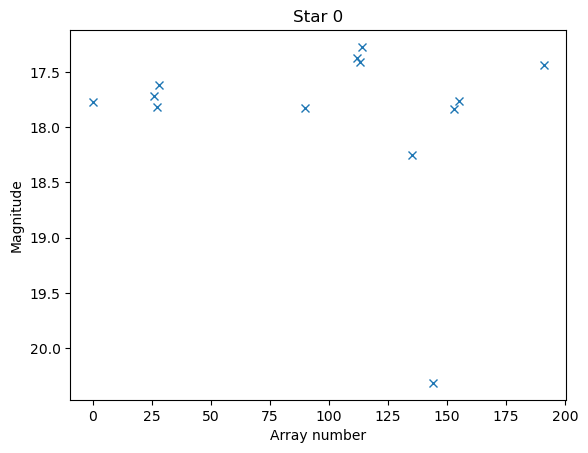

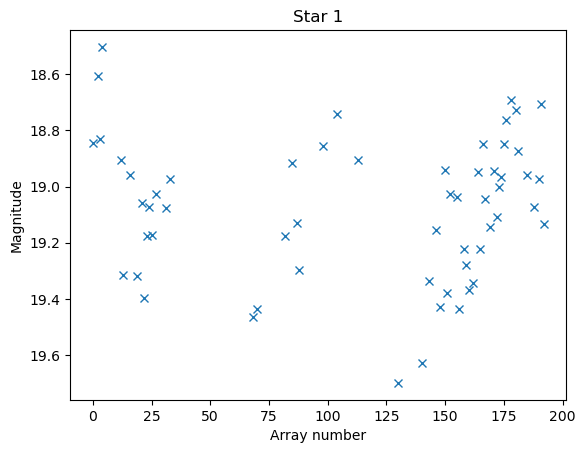

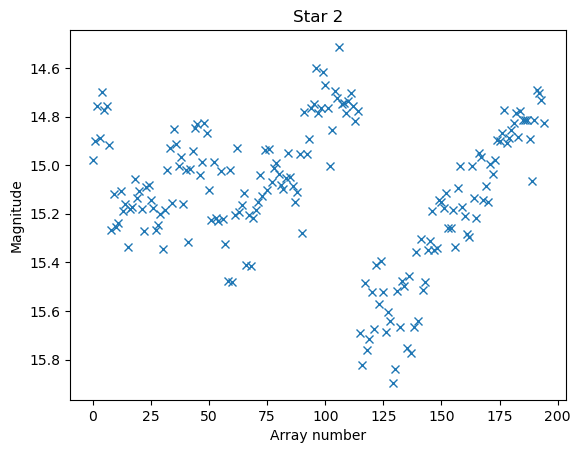

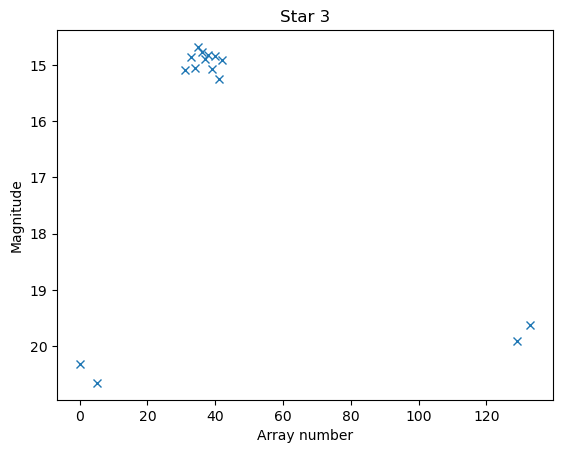

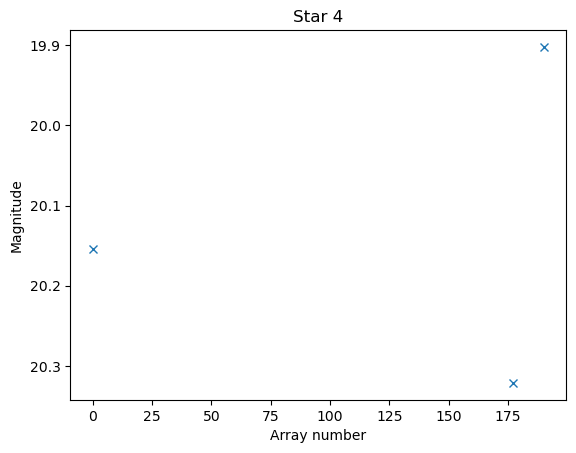

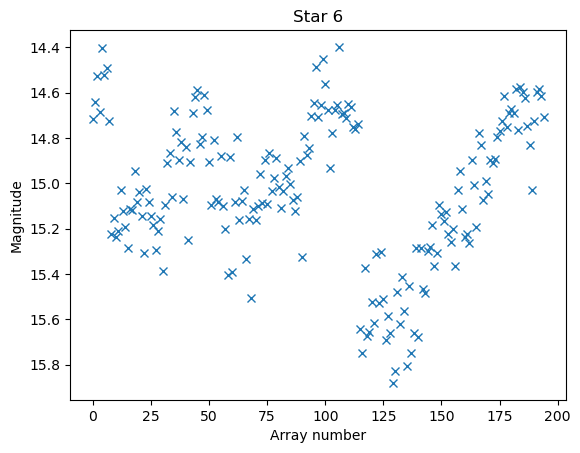

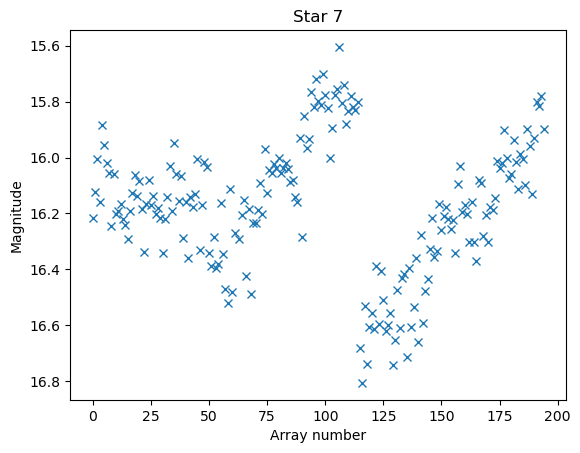

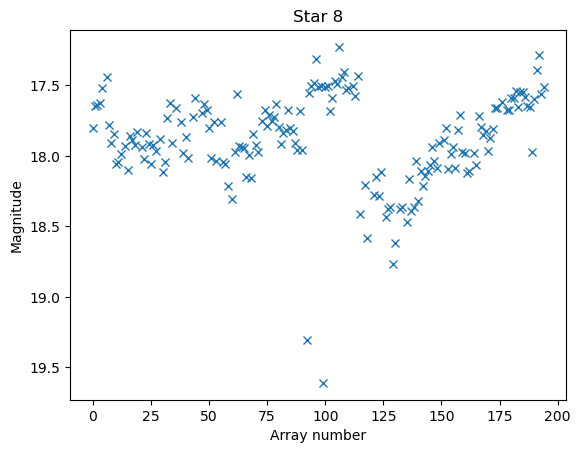

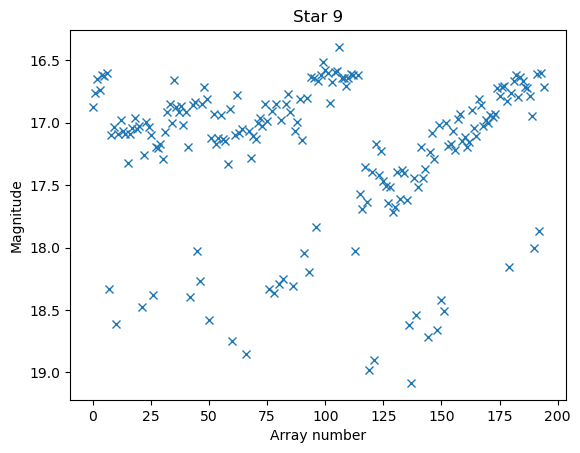

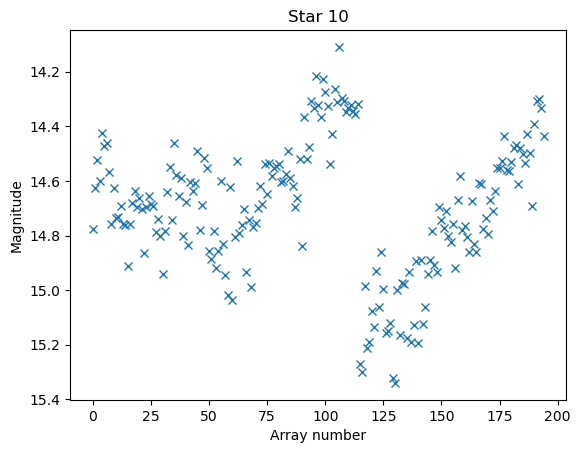

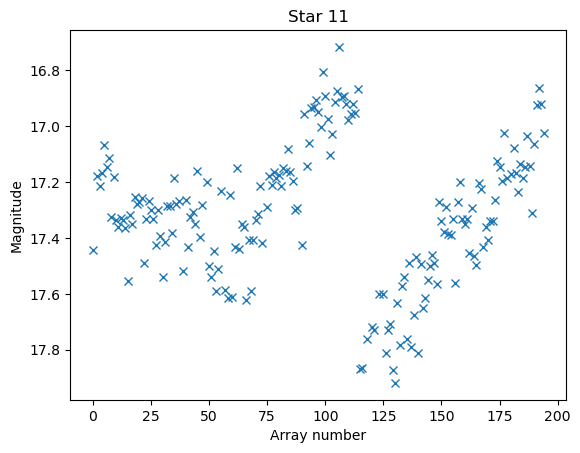

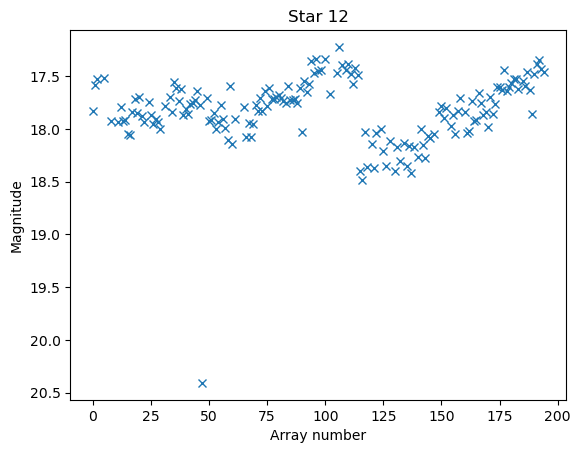

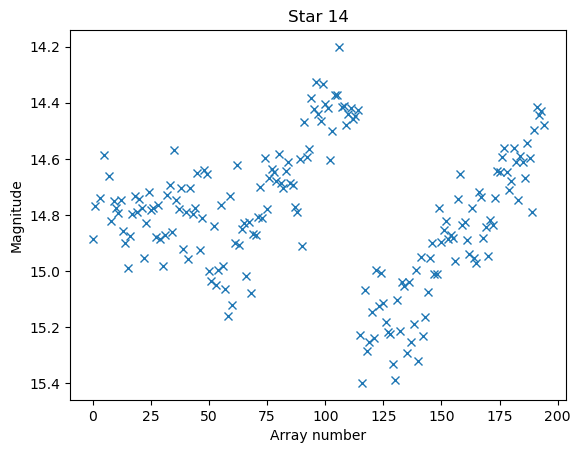

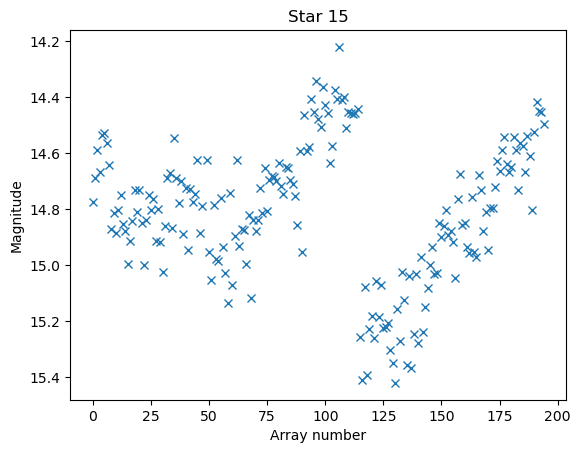

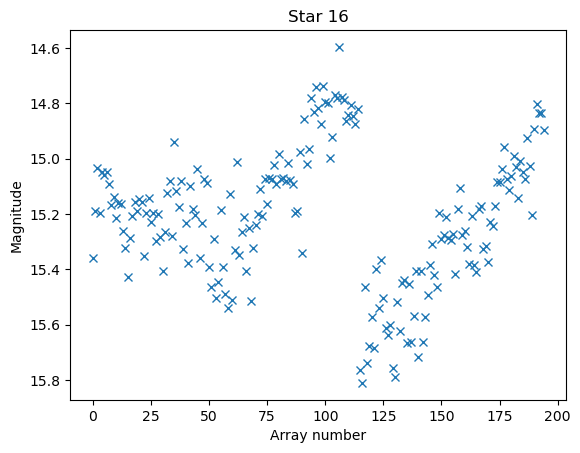

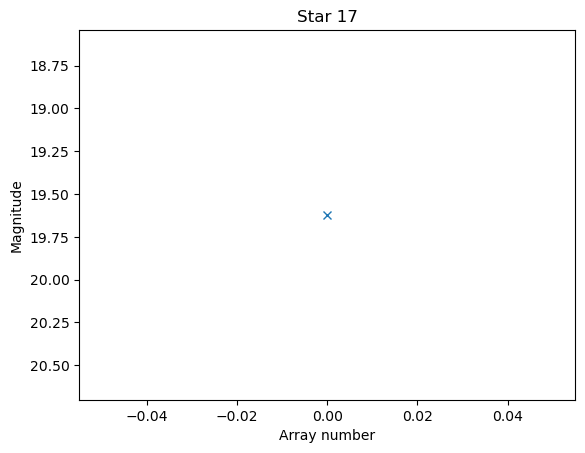

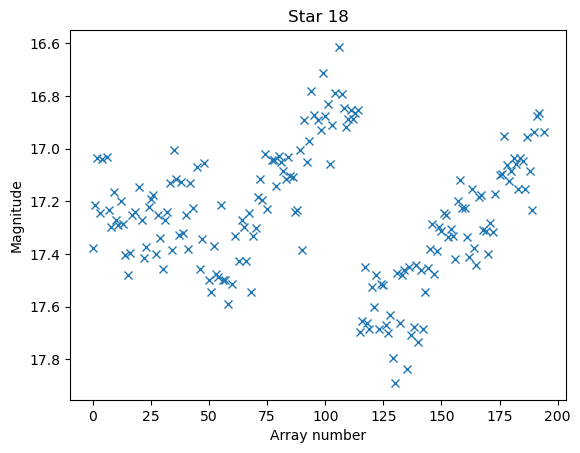

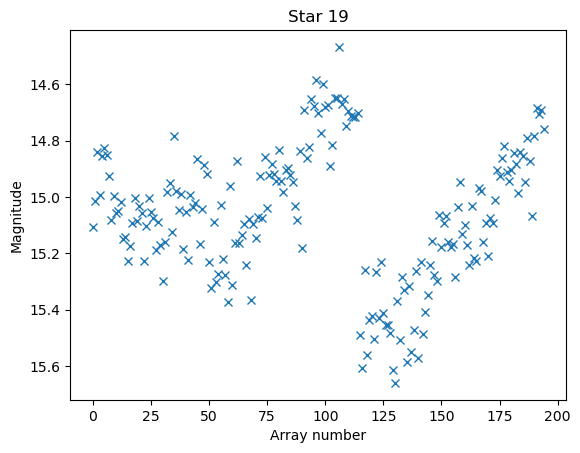

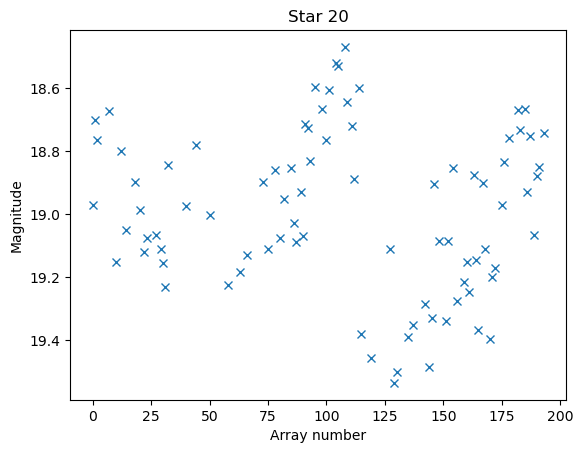

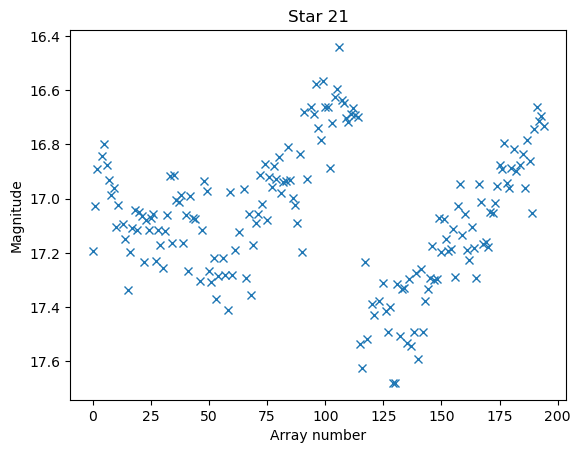

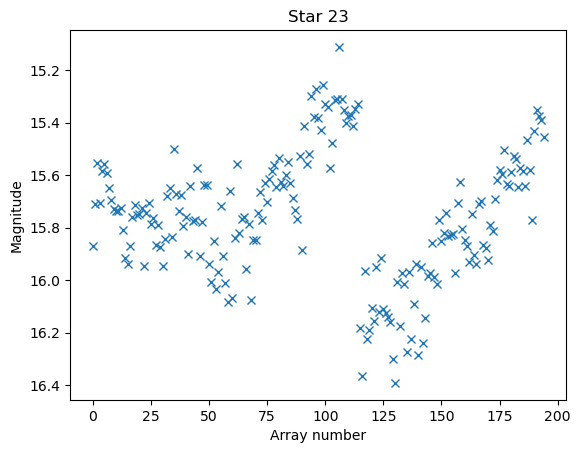

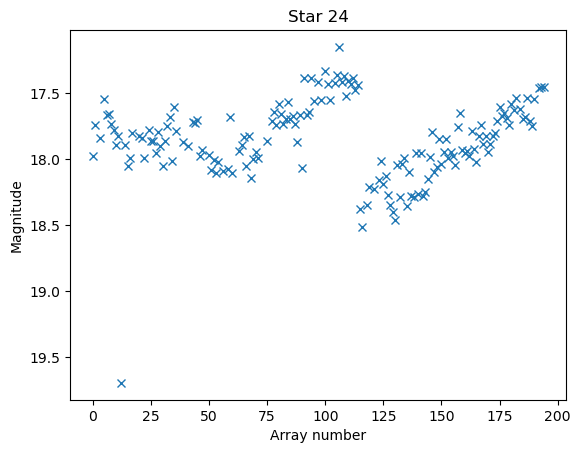

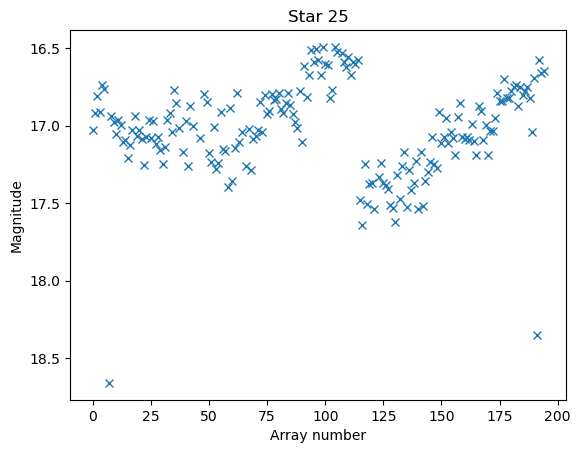

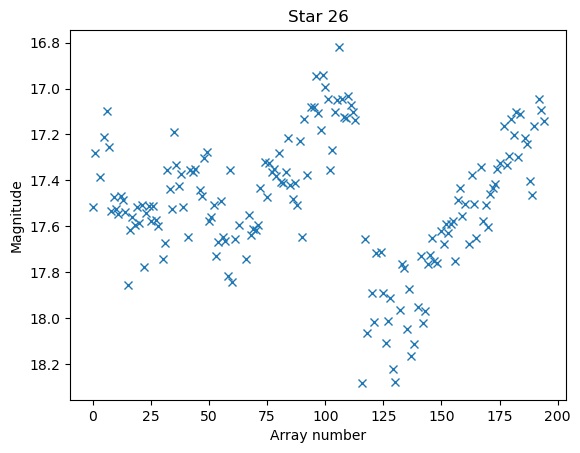

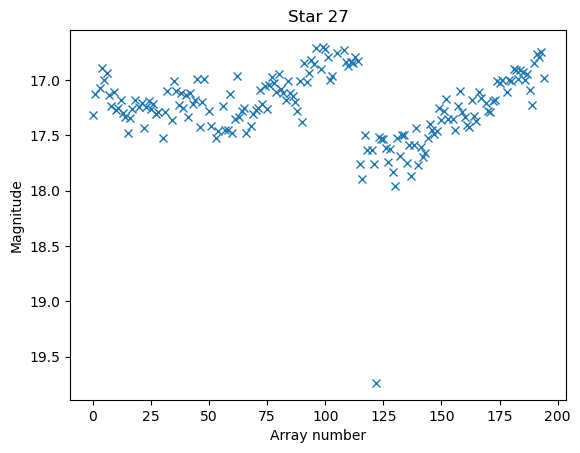

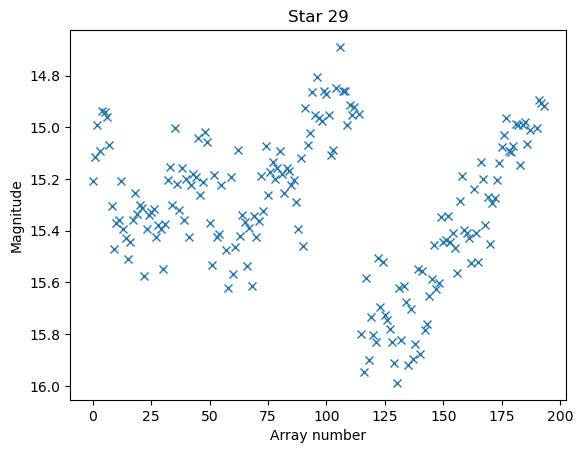

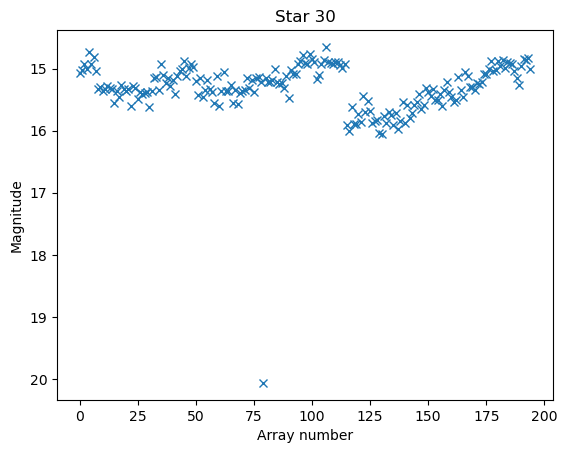

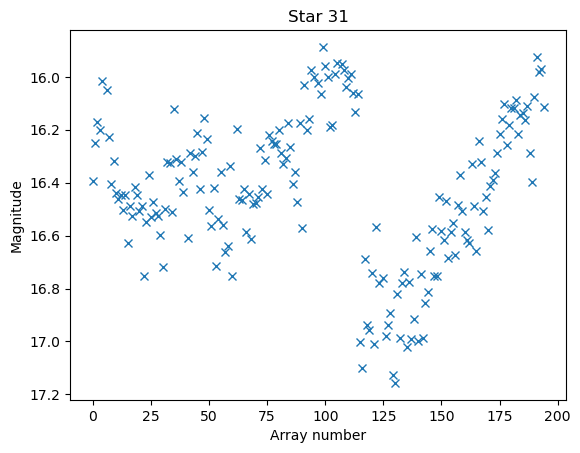

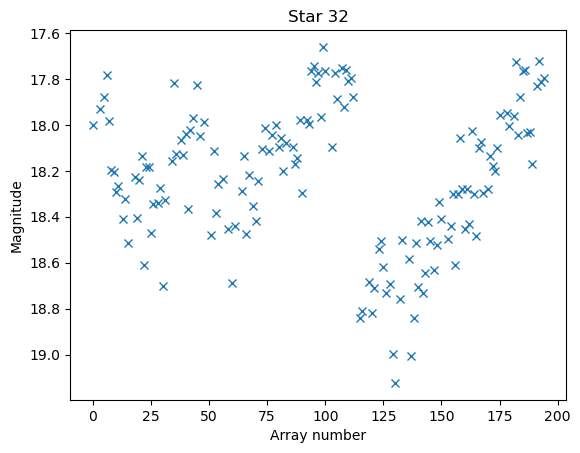

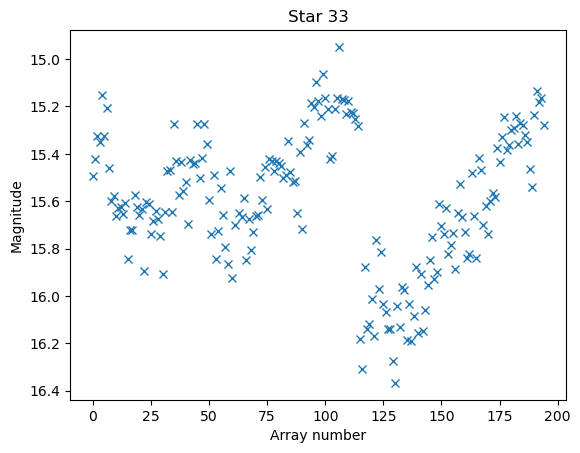

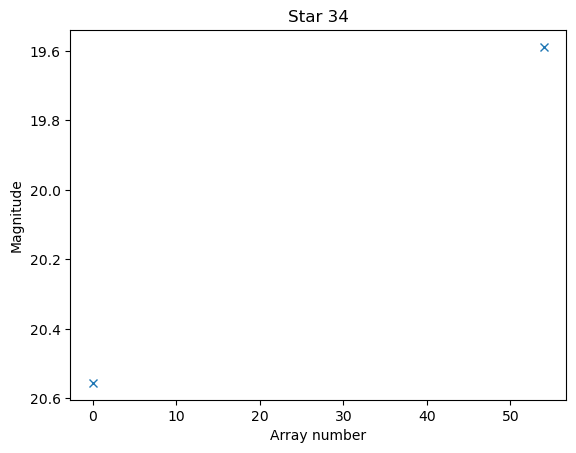

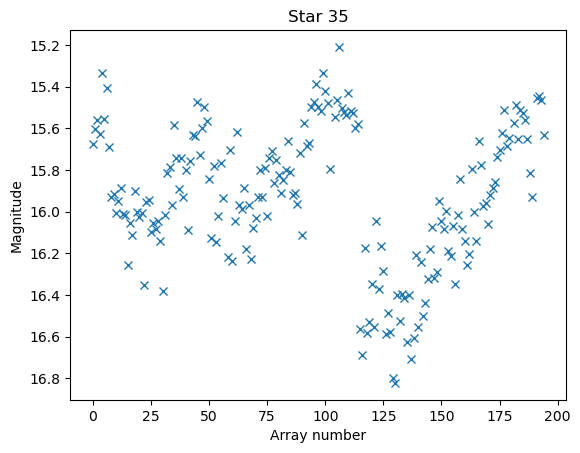

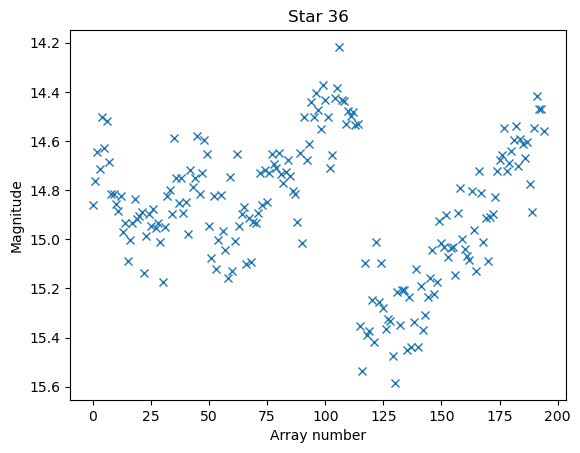

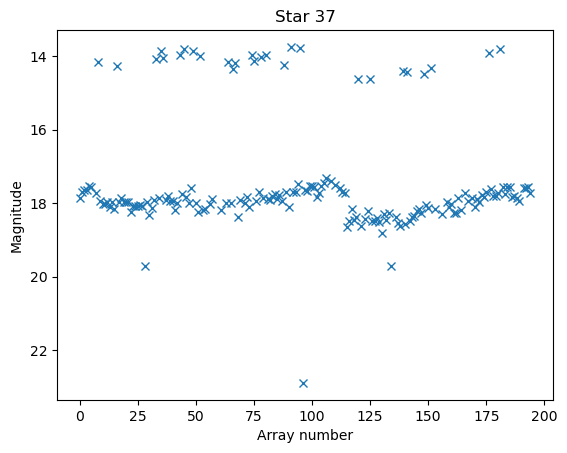

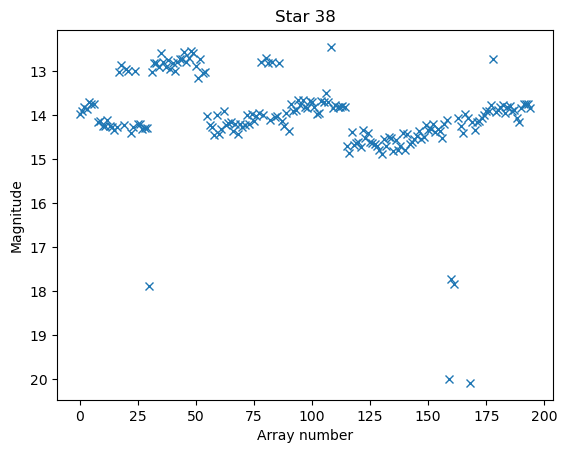

In [37]:
for index, lst in enumerate(magnitude_list_standard_stars):
    plt.plot(lst, 'x')
    plt.title(f'Star {stars_index[index]}')
    plt.xlabel('Array number')
    plt.ylabel('Magnitude')
    plt.gca().invert_yaxis()
    plt.show()
    plt.close()

In [38]:
bad_stars_index = [0, 3, 4, 8, 9, 12, 17, 24, 25, 27, 29, 30, 34, 37, 38]

corrected_stars_index = [i for i in range(len(sources_first_array_no_duplicates)) if i not in bad_stars_index and i not in saturated_stars_and_RV_UMa]

flux_list_standard_stars = [all_fluxes_transposed[i] for i in corrected_stars_index]
magnitude_list_standard_stars = [all_magnitudes_transposed[i] for i in corrected_stars_index]

In [39]:
# Now we transpose the all_magnitudes list so that each list contains all the magnitudes of each star
all_flux_offsets_standard_stars = list()
all_magnitude_offsets_standard_stars = list()
for index, flux_list in enumerate(all_fluxes_transposed):
    if index in corrected_stars_index:
        offset = [flux_list[0]- i for i in flux_list]
        all_flux_offsets_standard_stars.append(offset)

for index, flux_list in enumerate(all_magnitudes_transposed):
    if index in corrected_stars_index:
        offset = [flux_list[0]- i for i in flux_list]
        all_magnitude_offsets_standard_stars.append(offset)

In [40]:
mean_magnitude_offsets = np.nanmean(all_magnitude_offsets_standard_stars, axis = 0)
mean_flux_offsets = np.nanmean(all_flux_offsets_standard_stars, axis = 0)

std_magnitude_offsets = np.nanstd(all_magnitude_offsets_standard_stars, axis = 0)
std_flux_offsets = np.nanstd(all_flux_offsets_standard_stars, axis = 0)

In [41]:
import numpy as np
corrected_RV_UMa_flux = np.array(RV_UMa_fluxes[0]) + mean_flux_offsets
corrected_RV_UMa_magnitude = np.array(RV_UMa_magnitudes[0]) + mean_magnitude_offsets

# Plots

In [42]:
corrected_magnitudes = list()
for star in magnitude_list_standard_stars:
    corrected_magnitudes.append(np.array(star) + mean_magnitude_offsets)

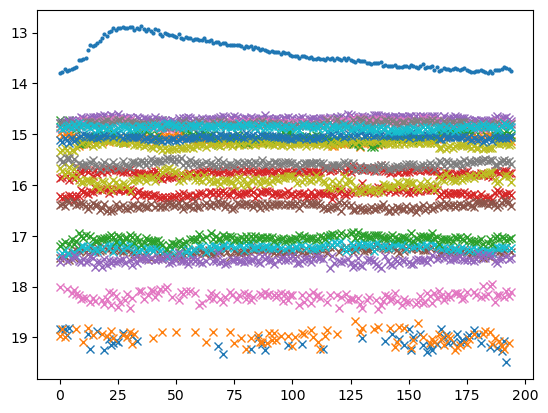

In [43]:
for index, star in enumerate(corrected_magnitudes):
    plt.plot(star, 'x', label = f'Star {corrected_stars_index[index]}')
plt.plot(corrected_RV_UMa_magnitude, 'o', markersize = 2)
# plt.legend()
plt.gca().invert_yaxis();

In [44]:
print('Corrected magnitudes')
print(np.mean(np.nanstd(corrected_magnitudes, axis = 1)))
print(max(np.nanstd(corrected_magnitudes, axis = 1)))
print('\n\n')
print('Corrected RV UMa')
print(np.nanmean(RV_UMa_magnitudes[0]))
print(np.nanstd(RV_UMa_magnitudes[0]))

Corrected magnitudes
0.06645297804818283
0.14381003852667035



Corrected RV UMa
13.425166909052143
0.3778974962568876


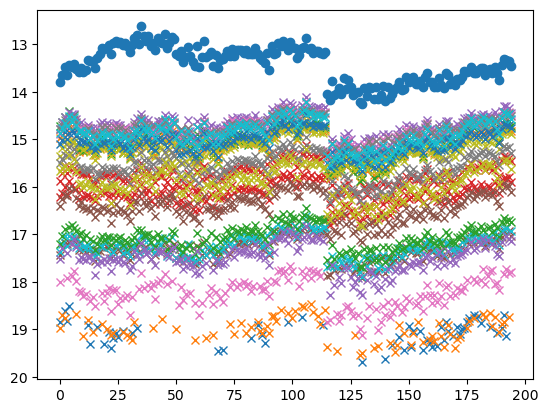

In [45]:
for star in magnitude_list_standard_stars:
    plt.plot(star, 'x')

plt.plot(RV_UMa_magnitudes[0], 'o')
plt.gca().invert_yaxis();

In [46]:
print('Not corrected magnitudes')
print(np.mean(np.nanstd(magnitude_list_standard_stars, axis = 1)))
print(max(np.nanstd(magnitude_list_standard_stars, axis = 1)))
print('Not corrected RV UMa')
print(np.mean(corrected_RV_UMa_magnitude))
print(np.std(corrected_RV_UMa_magnitude))

Not corrected magnitudes
0.2653236621031839
0.33535096877732107
Not corrected RV UMa
13.41518918230696
0.2782149389456028


# Plotting with time on the x-axis

In [47]:
import datetime

times = [datetime.datetime.strptime(header["DATE-OBS"], '%Y-%m-%dT%H:%M:%S.%f') for header in headers]
t = [(time - times[0]).total_seconds() for time in times]

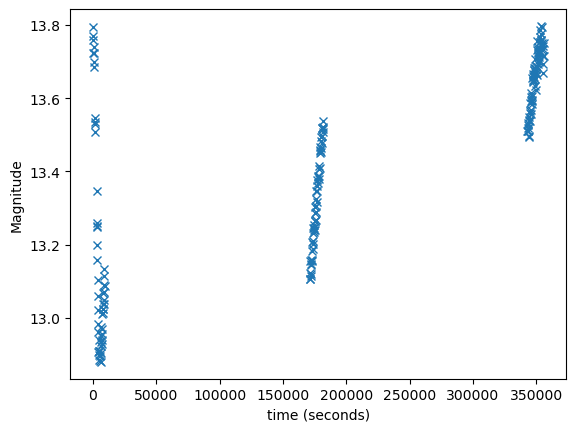

In [48]:
plt.plot(t, corrected_RV_UMa_magnitude, 'x')
plt.xlabel('time (seconds)')
plt.ylabel('Magnitude');

In [49]:
period = 0.47 # period in days
period_seconds = period*24*3600
phase = np.array(t)/period_seconds - np.floor(np.array(t)/period_seconds)

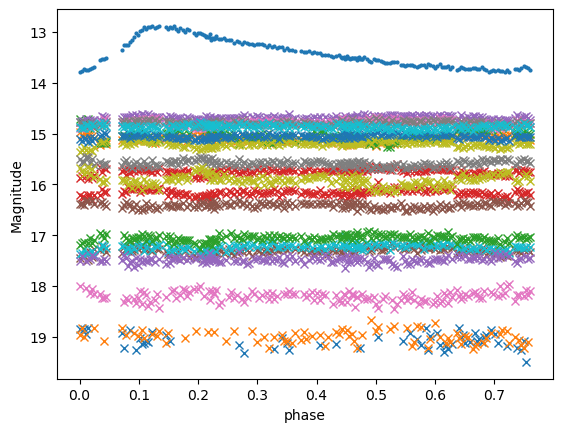

In [50]:
for index, star in enumerate(corrected_magnitudes):
    plt.plot(phase, star, 'x', label = f'Star {corrected_stars_index[index]}')
plt.plot(phase, corrected_RV_UMa_magnitude, 'o', markersize = 2)
# plt.legend()
plt.gca().invert_yaxis();
plt.xlabel('phase')
plt.ylabel('Magnitude');

In [51]:
# Move everything to txt file

with open(f'RV_UMaData{filter.upper()}.txt', 'w') as f:
    f.write(str(filter))
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(phase))
    f.write('\n\n\n***************************************************************\n\n\n')
    f.write(str(star))